## load the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report,\
confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

In [2]:
data_path = '../data/heart_disease.csv'

df = pd.read_csv(data_path)

NUMERIC_COLS = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
CATEGORICAL_COLS = [f for f in df.columns if f not in NUMERIC_COLS]

SELECTED_FEATS = ['thal_7', 'thalach', 'ca', 'cp_4', 'oldpeak', 'exang']

df.head(2)

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,slope,ca,target,cp_2,cp_3,cp_4,restecg_1,restecg_2,thal_6,thal_7
0,63.0,1.0,145.0,233.0,1.0,150.0,0.0,2.3,3.0,0.0,0,0,0,0,0,1,1,0
1,67.0,1.0,160.0,286.0,0.0,108.0,1.0,1.5,2.0,3.0,1,0,0,1,0,1,0,0


# classification models

- Didn't use `SELECTED_FEATS` with decision-trees models since they have built-in feature selection and might perform better with more features available

In [3]:
# split the data
X = df.drop("target", axis=1)
y = df["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [4]:
# scale the numeric data (with selected features)
scaler = StandardScaler()
X_train_scaled = X_train.copy()[SELECTED_FEATS]
X_test_scaled = X_test.copy()[SELECTED_FEATS]
num_cols = list(set(NUMERIC_COLS) & set(SELECTED_FEATS))
X_train_scaled[num_cols] = scaler.fit_transform(X_train_scaled[num_cols])
X_test_scaled[num_cols] = scaler.transform(X_test_scaled[num_cols])

In [5]:
y_pred = pd.DataFrame()
y_prob = pd.DataFrame()

- Used `SELECTED_FEATS` with the scaled data only, since it'll affect the accuracy of models like (logistic regression and SVM)<br/>
- On the other hand **tree-based** models automatically **ignore** irrelevant features and even **weak** features can contribute to better splits

## Logistic Regression

In [6]:
# train model
lr = LogisticRegression(random_state=42)
lr.fit(X_train_scaled, y_train)
# store predictions
y_pred['logisticRegression'] = lr.predict(X_test_scaled)
y_prob['logisticRegression'] = lr.predict_proba(X_test_scaled)[:,1]

## Support Vector Machine (SVM)

In [7]:
# train model
svm = SVC(kernel="rbf", C=1, random_state=42, probability=True)  
svm.fit(X_train_scaled, y_train)
# store predictions
y_pred['supportVectorMachine'] = svm.predict(X_test_scaled)
y_prob['supportVectorMachine'] = svm.predict_proba(X_test_scaled)[:,1]

## Decision Tree

In [8]:
# train model
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
# store predictions
y_pred['decisionTree'] = dt.predict(X_test)
y_prob['decisionTree'] = dt.predict_proba(X_test)[:,1]

## Random Forest

In [9]:
# train model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
# store predictions
y_pred['randomForest'] = rf.predict(X_test)
y_prob['randomForest'] = rf.predict_proba(X_test)[:,1]

# Evaluation

                  Model  Accuracy  Precision    Recall  F1-score       AUC
0    logisticRegression  0.901639   0.866667  0.928571  0.896552  0.957792
1  supportVectorMachine  0.868852   0.812500  0.928571  0.866667  0.969697
2          decisionTree  0.868852   0.812500  0.928571  0.866667  0.873377
3          randomForest  0.918033   0.870968  0.964286  0.915254  0.951299


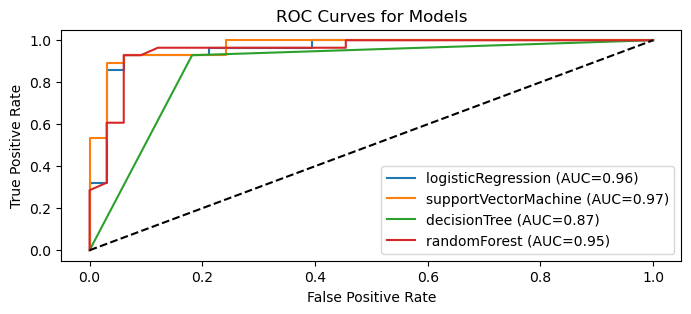

In [10]:
results = []

plt.figure(figsize=(8,3))

for model in y_pred.columns:

    # Metrics
    acc = accuracy_score(y_test, y_pred[model])
    prec = precision_score(y_test, y_pred[model])
    rec = recall_score(y_test, y_pred[model])
    f1 = f1_score(y_test, y_pred[model])
    auc = roc_auc_score(y_test, y_prob[model])

    results.append([model, acc, prec, rec, f1, auc])

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_prob[model])
    plt.plot(fpr, tpr, label=f"{model} (AUC={auc:.2f})")

# Results Table
results_df = pd.DataFrame(results, columns=["Model","Accuracy","Precision","Recall","F1-score","AUC"])
print(results_df)

# Plot ROC Curve
plt.plot([0,1],[0,1],'k--')  # diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Models")
plt.legend()
plt.show()